In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

In [3]:
from torchvision.io import read_image

def load_img(fname):
    img = read_image(fname)
    x = img / 255.
    
    transform = transforms.Compose([
        transforms.Resize((20, 20)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    return transform(x)

In [4]:
import pandas as pd

train_features = pd.read_csv(f"../data/image_labels.csv")

train_features.columns

Index(['image_path', 'label'], dtype='object')

In [5]:
img_path = "../data/corners"

# Load and transform images 
images = torch.stack([load_img(f"{img_path}/{item['image_path']}") for _, item in  train_features.iterrows()])

# Select label(s) from train_features
labels = train_features['label']
# Leave values that only 1 or 0 and convert to float just for simplicity
labels.replace('-', 0, inplace=True)
labels.replace('D', 1, inplace=True)
labels.replace('E', 2, inplace=True)
labels = torch.from_numpy(labels.to_numpy()).float()

C:\Users\mbred\AppData\Local\Temp\ipykernel_21104\1492300530.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels.replace('E', 2, inplace=True)


In [7]:
images.shape, labels.shape

(torch.Size([64, 3, 20, 20]), torch.Size([64]))

In [8]:
processed_dataset = TensorDataset(images, labels)

# Set proportion and split dataset into train and validation parts
proportion = 0.8

train_dataset, val_dataset = torch.utils.data.random_split(
    processed_dataset,
   [(int(len(images) * proportion)), len(images) - int(len(images) * proportion)],
)

In [9]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.36258528..2.2710087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70339924..2.0959387].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7645023..2.2710087].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.2009807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8707419..0.7818877].


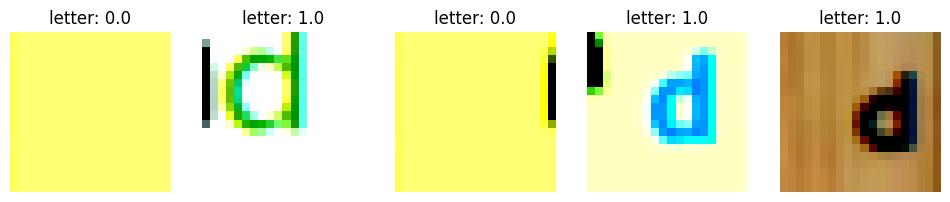

In [10]:
import matplotlib.pyplot as plt


for images, labels in train_loader:
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        ax = axes[i]

        img = images[i]
        img = img.permute(1, 2, 0)

        ax.imshow(img)
        ax.set_title(f'letter: {labels[i].item()}')
        ax.axis('off')
    plt.show()
    break

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%')

# Save the model
torch.save(model.state_dict(), '../models/letter_detection_model.pt')

Epoch 1/20, Loss: 1.0635914206504822
Validation Loss: 1.05495023727417, Accuracy: 53.84615384615385%
Epoch 2/20, Loss: 1.0149334967136383
Validation Loss: 1.1541976928710938, Accuracy: 53.84615384615385%
Epoch 3/20, Loss: 1.0164308845996857
Validation Loss: 1.1027661561965942, Accuracy: 53.84615384615385%
Epoch 4/20, Loss: 0.9782910645008087
Validation Loss: 1.0992448329925537, Accuracy: 53.84615384615385%
Epoch 5/20, Loss: 0.9295107126235962
Validation Loss: 1.1534361839294434, Accuracy: 38.46153846153846%
Epoch 6/20, Loss: 0.8828927278518677
Validation Loss: 1.0729700326919556, Accuracy: 53.84615384615385%
Epoch 7/20, Loss: 0.8405037522315979
Validation Loss: 1.0935766696929932, Accuracy: 53.84615384615385%
Epoch 8/20, Loss: 0.7146559655666351
Validation Loss: 1.0745339393615723, Accuracy: 46.15384615384615%
Epoch 9/20, Loss: 0.6643781065940857
Validation Loss: 1.0688023567199707, Accuracy: 46.15384615384615%
Epoch 10/20, Loss: 0.5355396270751953
Validation Loss: 1.0598031282424927, 

In [15]:
model = SimpleCNN()
model.load_state_dict(torch.load('../models/letter_detection_model.pt'))
model.eval()

with torch.no_grad():
    for inputs, labels in train_loader: #Change loader to some different input
        labels = labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        print(f'Predicted: {predicted}, Actual: {labels}')

Predicted: tensor([0, 1, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
        1, 0, 1, 1, 0, 0, 2, 0]), Actual: tensor([0, 1, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 2, 0])
Predicted: tensor([2, 1, 0, 1, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 2, 0, 0, 1, 0]), Actual: tensor([2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0])


C:\Users\mbred\AppData\Local\Temp\ipykernel_21104\3416725406.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/letter_detection